In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
import string
from tqdm import tqdm
import re
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
recs = pd.read_csv('verified_recs.csv', header=None).dropna()
recs.columns = ["d_id", "doc_name", "recs"]

In [4]:
recs['d_id'].value_counts() #normalize=True) * 100

23.0    566
4.0      54
3.0      43
7.0      33
1.0      28
6.0      15
11.0     13
8.0      11
19.0     10
12.0      9
20.0      8
2.0       7
17.0      6
21.0      6
16.0      5
15.0      4
10.0      3
22.0      2
Name: d_id, dtype: int64

In [5]:
test_ids = [19, 12, 20, 2, 17, 21, 16, 15, 10, 22, 6]
len(test_ids)

11

In [6]:
test = recs.loc[recs.d_id.isin(test_ids)].recs
train = recs.loc[~recs.d_id.isin(test_ids)].recs

In [7]:
train.shape[0], test.shape[0]

(748, 75)

In [8]:
recs

,d_id,doc_name,recs
0,1.0,ED586970.pdf,School districts must ensure that personally i...
1,1.0,ED586970.pdf,Identify and recognize risks and vulnerabiliti...
2,1.0,ED586970.pdf,Design systems and services with a design-for-...
3,1.0,ED586970.pdf,Consider the benefits of a diverse combination...
4,1.0,ED586970.pdf,Leverage partnerships with agencies and extern...
...,...,...,...
846,23.0,CSC-Final-Report,To fully understand and prepare to counter the...
847,23.0,CSC-Final-Report,This assessment should include the \nfollowing...
848,23.0,CSC-Final-Report,This assessment should include the \nfollowing...
849,23.0,CSC-Final-Report,This assessment should include the \nfollowing...


In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shubham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
import pickle, os, difflib, random
from sklearn.model_selection import train_test_split

def load_list_from_pickle(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

# Example usage:
filename = os.path.join('pkl_files', "all_sentences.pkl")
sentences = load_list_from_pickle(filename)

In [14]:
recs.shape, len(sentences)

((823, 3), 19666)

In [20]:
sentence_list_tokens = [s.split() for s in sentences]
def retrieve_sentence_index(sentence):
    # Tokenize the sentences
    sentence_tokens = sentence.split()
    
    # Calculate the similarity between the sentences
    similarity_scores = [difflib.SequenceMatcher(None, sentence_tokens, s).ratio() for s in sentence_list_tokens]
    
    # Find the index of the most similar sentence
    max_similarity_index = similarity_scores.index(max(similarity_scores))
    
    return max_similarity_index

train_indices = [retrieve_sentence_index(sentence) for sentence in tqdm(train)]
test_indices = [retrieve_sentence_index(sentence) for sentence in tqdm(test)]
train_recs = [sentences[idx] for idx in set(train_indices)]
test_recs = [sentences[idx] for idx in set(test_indices)]

100%|██████████| 75/75 [00:26<00:00,  2.87it/s]


TypeError: object of type 'int' has no len()

In [22]:
non_recs = []
already_sampled = []
while len(non_recs) != recs.shape[0]:
    samp_idx = np.random.choice(len(sentences))
    if (samp_idx not in train_indices + test_indices + already_sampled) and (len(sentences[samp_idx].split()) > 10):
        already_sampled.append(samp_idx), non_recs.append(sentences[samp_idx])

train_non_recs = non_recs[:train.shape[0]]
test_non_recs = non_recs[train.shape[0]:]

train_texts = train_non_recs + train_recs
test_texts = test_non_recs + test_recs

train_labels = [0] * len(train_non_recs) + [1] * len(train_recs)
test_labels = [0] * len(test_non_recs) + [1] * len(test_recs)

train_combined = list(zip(train_texts, train_labels))
test_combined = list(zip(test_texts, test_labels))
# # Shuffle the combined lists
# random.shuffle(train_combined)
# random.shuffle(test_combined)

texts, labels = zip(*train_combined)
test_texts, test_labels = zip(*test_combined)

# # Split the data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

### Sentence Embeddings

In [23]:
import seaborn as sns
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [24]:
# sentences = train['Recommendation text'].to_numpy()
# sentence_embeddings = sbert_model.encode(sentences)
sentence_embeddings = sbert_model.encode(texts)

In [25]:
sentence_embeddings.shape

(1463, 768)

In [26]:
nonrecomm_embeddings = sentence_embeddings[:len(train_non_recs)]
recomm_embeddings = sentence_embeddings[len(train_non_recs):]

### K-Means Clustering

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


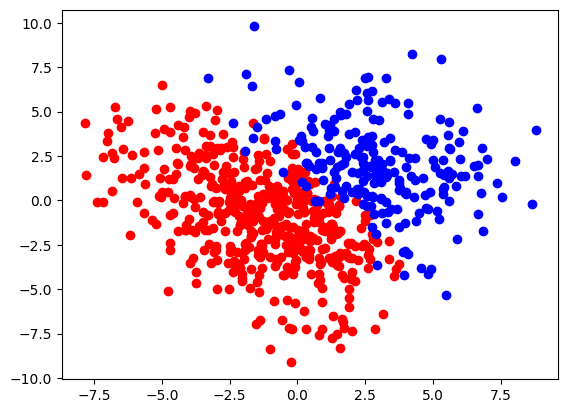

In [27]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(recomm_embeddings)

# Use PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(recomm_embeddings)

# Create a scatter plot of the reduced embeddings with different colors for each cluster
colors = ['red', 'blue', 'green', 'yellow', 'black', 'cyan']
for i in range(num_clusters):
    plt.scatter(reduced_embeddings[kmeans.labels_ == i, 0], 
                reduced_embeddings[kmeans.labels_ == i, 1], 
                c=colors[i], label=f'Cluster {i}')

### Cosine Similarity

In [28]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

matrix = np.identity(recomm_embeddings.shape[0])
for i in range(matrix.shape[0]):
  for j in range(i,matrix.shape[0]):
    matrix[i][j] = cosine(recomm_embeddings[i],recomm_embeddings[j])
    matrix[j][i] = matrix[i][j]

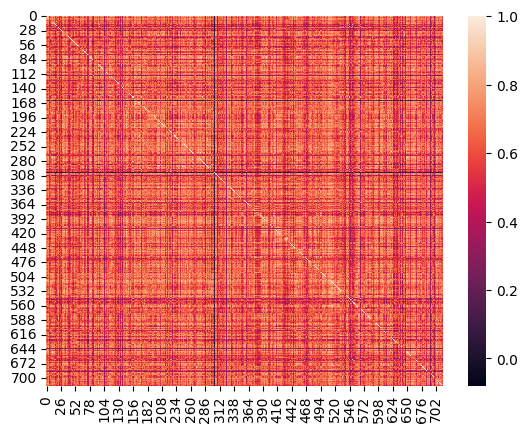

In [29]:
ax = sns.heatmap(matrix)

In [30]:
cluster1, cluster2 = kmeans.cluster_centers_

In [31]:
recomm_cosines = [max(cosine(cluster1, embedd), cosine(cluster2, embedd)) for embedd in recomm_embeddings]
nonrecomm_cosines = [max(cosine(cluster1, embedd), cosine(cluster2, embedd)) for embedd in nonrecomm_embeddings]

(array([  2.,   3.,  11.,  27.,  73., 119., 167., 185., 139.,  22.]),
 array([0.17730653, 0.25280756, 0.32830858, 0.40380958, 0.4793106 ,
        0.5548116 , 0.63031262, 0.70581365, 0.78131467, 0.8568157 ,
        0.93231672]),
 <BarContainer object of 10 artists>)

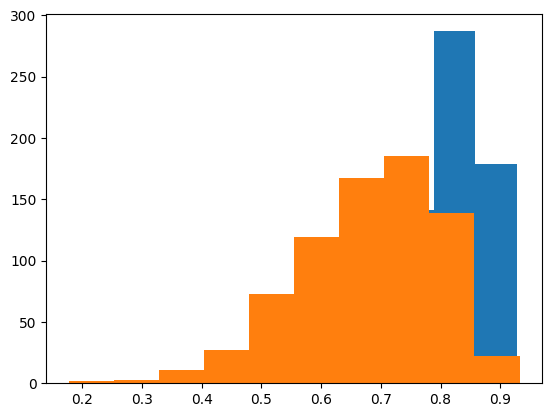

In [33]:
plt.hist(recomm_cosines)
plt.hist(nonrecomm_cosines)

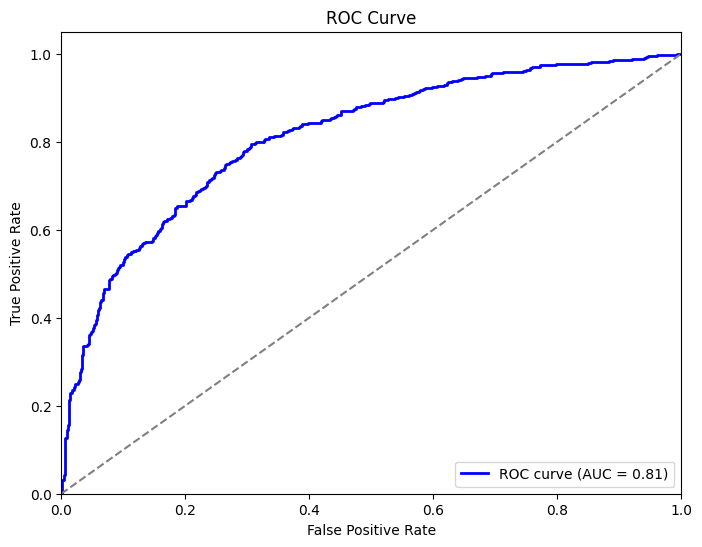

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = nonrecomm_cosines + recomm_cosines

roc_auc = roc_auc_score(labels, y_scores)
fpr, tpr, thresholds = roc_curve(labels, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [35]:
thresholds[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], fpr[np.argmax(tpr - fpr)]

(0.7518472, 0.7944055944055944, 0.30614973262032086)

In [36]:
tp = 96 * tpr[np.argmax(tpr - fpr)]
fp = np.round(110 * 0.2545454545454545)
fn = 96 - tp
tn = 110 - fp

accuracy = (tp + tn)/(tp + fp + tn + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

accuracy, precision, recall

(0.7682666847715391, 0.7314481944518968, 0.7944055944055944)

In [37]:
fp/sum([fp, tn]), fn/sum([tp, fn])

(0.2545454545454545, 0.20559440559440553)

In [38]:
np.mean(recomm_cosines)

0.79922223

### Testing

In [39]:
test_embeddings = sbert_model.encode(test_texts)

test_nonrecomm_embeddings = test_embeddings[:len(test_non_recs)]
test_recomm_embeddings = test_embeddings[len(test_non_recs):]

test_recomm_cosines = [max(cosine(cluster1, embedd), cosine(cluster2, embedd)) for embedd in test_recomm_embeddings]
test_nonrecomm_cosines = [max(cosine(cluster1, embedd), cosine(cluster2, embedd)) for embedd in test_nonrecomm_embeddings]

In [40]:
test_tp = len([cos for cos in test_recomm_cosines if cos >= thresholds[np.argmax(tpr - fpr)]])
test_fn = len([cos for cos in test_recomm_cosines if cos < thresholds[np.argmax(tpr - fpr)]])
test_fp = len([cos for cos in test_nonrecomm_cosines if cos >= thresholds[np.argmax(tpr - fpr)]])
test_tn = len([cos for cos in test_nonrecomm_cosines if cos < thresholds[np.argmax(tpr - fpr)]])

test_accuracy = (test_tp + test_tn)/(test_tp + test_fp + test_fn + test_tn)
test_precision = test_tp / (test_tp + test_fp)
test_recall = test_tp / (test_tp + test_fn)

test_accuracy, test_precision, test_recall

(0.7466666666666667, 0.7466666666666667, 0.7466666666666667)

In [41]:
test_fp/sum([test_fp, test_tn]), test_fn/sum([test_tp, test_fn])

(0.25333333333333335, 0.25333333333333335)